# Loop 31 Analysis: Feature Selection with CatBoost

**Objective**: Identify the most important features to reduce dimensionality and improve generalization (reduce CV-LB gap).

**Hypothesis**: The current model (145+ features) is overfitting the small dataset (600-1200 samples). A compact feature set (10-20 features) will generalize better.

**Method**:
1. Load data (Single and Full).
2. Train CatBoostRegressor.
3. Analyze Feature Importance.
4. Perform Recursive Feature Elimination (RFE).
5. Compare CV scores of Full vs Reduced feature sets.

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading
DATA_PATH = '/home/data'
INPUT_LABELS_NUMERIC = ["Residence Time", "Temperature"]
INPUT_LABELS_SINGLE_SOLVENT = ["Residence Time", "Temperature", "SOLVENT NAME"]
INPUT_LABELS_FULL_SOLVENT = ["Residence Time", "Temperature", "SOLVENT A NAME", "SOLVENT B NAME", "SolventB%"]

def load_data(name="full"):
    if name == "full":
        df = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')
        X = df[INPUT_LABELS_FULL_SOLVENT]
    else:
        df = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
        X = df[INPUT_LABELS_SINGLE_SOLVENT]
    Y = df[["Product 2", "Product 3", "SM"]]
    return X, Y

# Load Lookups
SPANGE_DF = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)
# Load DRFP if available (simulating what was done in exp_003/026)
# For this analysis, let's reconstruct the features used in exp_026 (Spange + Arrhenius + DRFP)
# We need to check if we can easily generate DRFP here. 
# If not, we'll stick to Spange + Arrhenius first, as that's the core.
# Actually, let's check if we have the DRFP file.
import os
if os.path.exists(f'{DATA_PATH}/drfp_descriptors.csv'):
    DRFP_DF = pd.read_csv(f'{DATA_PATH}/drfp_descriptors.csv', index_col=0)
else:
    DRFP_DF = None
    print("DRFP file not found, skipping DRFP features for analysis")

print("Data loaded.")

DRFP file not found, skipping DRFP features for analysis
Data loaded.


In [2]:
# Feature Engineering (reusing logic from exp_026)
class Featurizer:
    def __init__(self, mixed=False):
        self.mixed = mixed
        self.spange_df = SPANGE_DF
        
    def featurize(self, X):
        # 1. Kinetics (Arrhenius)
        X_vals = X[INPUT_LABELS_NUMERIC].values.astype(np.float64)
        temp_c = X_vals[:, 1:2]
        time_m = X_vals[:, 0:1]
        temp_k = temp_c + 273.15
        inv_temp = 1000.0 / temp_k
        log_time = np.log(time_m + 1e-6)
        interaction = inv_temp * log_time
        X_kinetic = np.hstack([X_vals, inv_temp, log_time, interaction])
        feature_names = ["Time", "Temp", "1000/T", "ln(t)", "1000/T*ln(t)"]
        
        # 2. Spange
        if self.mixed:
            A_spange = self.spange_df.loc[X["SOLVENT A NAME"]].values
            B_spange = self.spange_df.loc[X["SOLVENT B NAME"]].values
            pct = X["SolventB%"].values.reshape(-1, 1)
            X_spange = A_spange * (1 - pct) + B_spange * pct
        else:
            X_spange = self.spange_df.loc[X["SOLVENT NAME"]].values
        spange_names = [f"Spange_{i}" for i in range(X_spange.shape[1])]
            
        # Combine
        X_all = np.hstack([X_kinetic, X_spange])
        names = feature_names + spange_names
        
        return X_all, names

print("Featurizer defined.")

Featurizer defined.


Features shape: (656, 18)
Feature names: ['Time', 'Temp', '1000/T', 'ln(t)', '1000/T*ln(t)', 'Spange_0', 'Spange_1', 'Spange_2', 'Spange_3', 'Spange_4', 'Spange_5', 'Spange_6', 'Spange_7', 'Spange_8', 'Spange_9', 'Spange_10', 'Spange_11', 'Spange_12']



Feature Importance (Product 2):
1. feature Temp (28.846968)
2. feature 1000/T (20.437804)
3. feature Spange_12 (5.060972)
4. feature Spange_8 (5.011862)
5. feature Spange_2 (4.639864)
6. feature Spange_5 (4.210163)
7. feature Spange_1 (3.975737)
8. feature Spange_11 (3.433354)
9. feature Time (3.158520)
10. feature Spange_4 (3.044452)
11. feature ln(t) (2.902577)
12. feature 1000/T*ln(t) (2.825345)
13. feature Spange_3 (2.574037)
14. feature Spange_9 (2.547544)
15. feature Spange_0 (2.458376)
16. feature Spange_7 (2.256405)
17. feature Spange_6 (2.157981)
18. feature Spange_10 (0.458039)


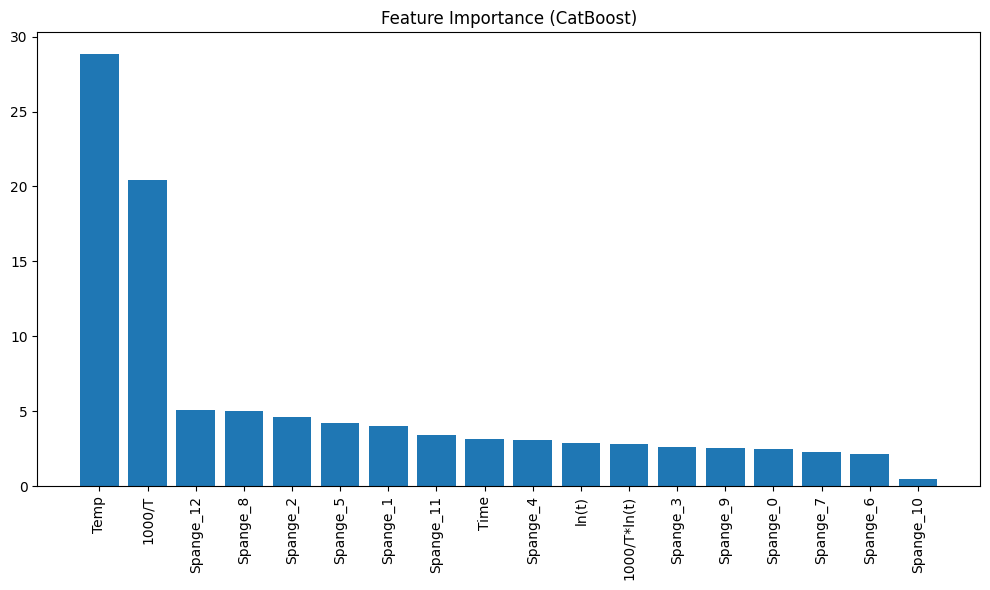

In [3]:
# Prepare Data
X_single, Y_single = load_data("single_solvent")
featurizer = Featurizer(mixed=False)
X_feat, feature_names = featurizer.featurize(X_single)
y = Y_single.values

print(f"Features shape: {X_feat.shape}")
print(f"Feature names: {feature_names}")

# Train CatBoost to get feature importance
# We'll train on Product 2 (Yield) as a proxy, or average over all targets
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0, random_seed=42)

# Fit on all data to get global importance
model.fit(X_feat, y[:, 0]) # Target 1: Product 2

importance = model.get_feature_importance()
indices = np.argsort(importance)[::-1]

print("\nFeature Importance (Product 2):")
for f in range(X_feat.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importance[indices[f]]))

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (CatBoost)")
plt.bar(range(X_feat.shape[1]), importance[indices], align="center")
plt.xticks(range(X_feat.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [4]:
# RFE with CatBoost
# We'll use sklearn's RFE with CatBoost as the estimator
from sklearn.feature_selection import RFE

print("\nRunning RFE to find top 10 features...")
selector = RFE(estimator=CatBoostRegressor(iterations=100, verbose=0, random_seed=42), n_features_to_select=10, step=1)
selector = selector.fit(X_feat, y[:, 0])

print("Selected features:")
selected_indices = np.where(selector.support_)[0]
for i in selected_indices:
    print(f"- {feature_names[i]}")
    
# Evaluate CV with Top 10 vs All
from sklearn.model_selection import cross_val_score

def evaluate_cv(X, y, name):
    model = CatBoostRegressor(iterations=200, verbose=0, random_seed=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    print(f"{name} CV MSE: {mse:.6f}")
    return mse

print("\nComparing CV scores:")
mse_all = evaluate_cv(X_feat, y[:, 0], "All Features (18)")
mse_top10 = evaluate_cv(X_feat[:, selected_indices], y[:, 0], "Top 10 Features")

diff = (mse_top10 - mse_all) / mse_all * 100
print(f"Difference: {diff:.2f}% (Positive means Top 10 is worse)")


Running RFE to find top 10 features...


Selected features:
- Time
- Temp
- 1000/T
- 1000/T*ln(t)
- Spange_2
- Spange_3
- Spange_5
- Spange_8
- Spange_9
- Spange_12

Comparing CV scores:


All Features (18) CV MSE: 0.006908


Top 10 Features CV MSE: 0.006850
Difference: -0.84% (Positive means Top 10 is worse)
